
Image Registry Summary
Total Images: 62
Total Classes: 2

Class Distribution:
  - BK: 27 images
  - FK: 35 images

✓ Registry saved to: ../dataset.csv
✓ Total images: 62
✓ Total classes: 2
✓ Random seed set to: 42
✓ Deterministic mode enabled for reproducibility

Runtime Configuration
Operating System: Darwin
PyTorch Version: 2.8.0
Device Type: MPS
Device Name: Apple Silicon GPU (Metal Performance Shaders)
MPS Backend: Enabled
Note: Using Apple Silicon GPU acceleration

✓ Runtime configured successfully!
✓ Using device: mps
✓ Loaded 62 samples from ../dataset.csv

Data Split Summary
Train set: 36 samples (58.1%)
Val set:   13 samples (21.0%)
Test set:  13 samples (21.0%)
Total:     62 samples



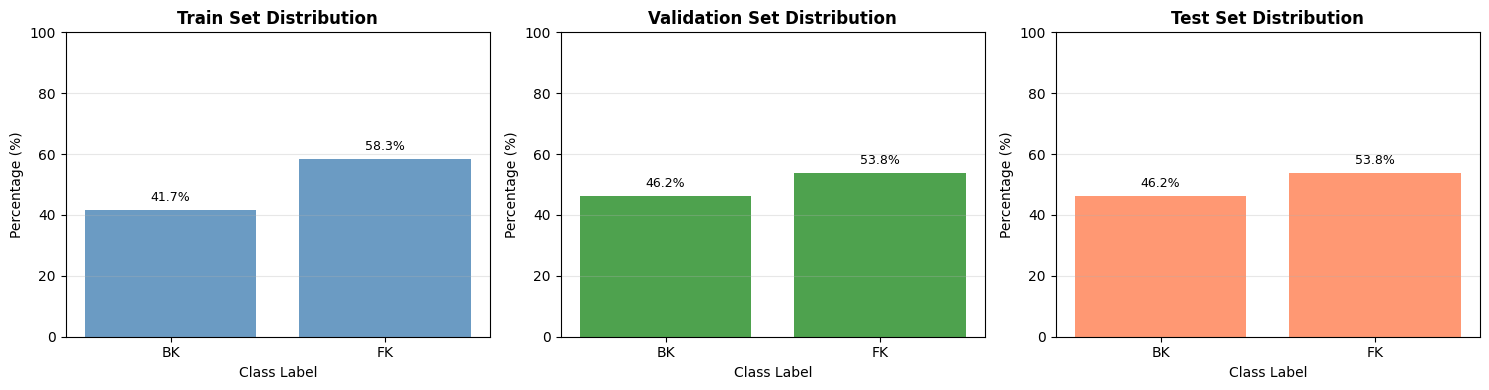

Class Distribution Summary:
Split        Class      Percentage   Count   
--------------------------------------------------
Train        BK           41.7%         15
Train        FK           58.3%         21
Validation   BK           46.2%          6
Validation   FK           53.8%          7
Test         BK           46.2%          6
Test         FK           53.8%          7
✓ Train set saved to: ../train.csv
✓ Validation set saved to: ../val.csv
✓ Test set saved to: ../test.csv


In [1]:
from module.preprocess import ImageRegistryBuilder
from module.config import RuntimeConfig
from module.dataspliter import DataSplitter

builder = ImageRegistryBuilder(root_dir='../images')
builder.scan_directory()
builder.print_summary()
builder.save_to_csv(output_path='../dataset.csv', use_relative_paths=True)

# Initialize and setup the runtime configuration
runtime = RuntimeConfig(seed=42, verbose=True)
device = runtime.setup()

print(f"✓ Runtime configured successfully!")
print(f"✓ Using device: {device}")
# Create and run the data splitter

splitter = DataSplitter(csv_path='../dataset.csv', train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42)
train_df, val_df, test_df = splitter.split_data()
splitter.plot_distributions()
splitter.save_splits(train_path='../train.csv', val_path='../val.csv', test_path='../test.csv')

In [ ]:
from module.dataset import ImageDataset

# Create datasets for train, validation, and test (without transforms for now)
train_dataset = ImageDataset(dataframe=train_df, root_dir='..', transform=None)
val_dataset = ImageDataset(dataframe=val_df, root_dir='..', 
                           transform=None, label_encoder=train_dataset.get_label_encoder())
test_dataset = ImageDataset(dataframe=test_df, root_dir='..', 
                            transform=None, label_encoder=train_dataset.get_label_encoder())

# Print information
print("Training Dataset:")
train_dataset.print_info()

print("Validation Dataset:")
val_dataset.print_info()

print("Test Dataset:")
test_dataset.print_info()

# Display label encoder
print("Label Encoder:", train_dataset.get_label_encoder())

from module.transform import ImageTransforms
# Create image transforms
image_transforms = ImageTransforms(image_size=224, augment_training=True)
image_transforms.print_info()

# Recreate datasets with transforms
train_dataset = ImageDataset(dataframe=train_df, root_dir='..', 
                             transform=image_transforms.get_train_transform())
val_dataset = ImageDataset(dataframe=val_df, root_dir='..', 
                           transform=image_transforms.get_test_transform(),
                           label_encoder=train_dataset.get_label_encoder())
test_dataset = ImageDataset(dataframe=test_df, root_dir='..', 
                            transform=image_transforms.get_test_transform(),
                            label_encoder=train_dataset.get_label_encoder())

print("✓ Datasets recreated with transforms!")
print(f"✓ Train dataset: {len(train_dataset)} samples with augmentation")
print(f"✓ Val dataset: {len(val_dataset)} samples without augmentation")
print(f"✓ Test dataset: {len(test_dataset)} samples without augmentation")

Training Dataset:

Dataset Information
Total samples: 36
Number of classes: 2

Label Encoding:
  BK → 0 (15 samples)
  FK → 1 (21 samples)

Validation Dataset:

Dataset Information
Total samples: 13
Number of classes: 2

Label Encoding:
  BK → 0 (6 samples)
  FK → 1 (7 samples)

Test Dataset:

Dataset Information
Total samples: 13
Number of classes: 2

Label Encoding:
  BK → 0 (6 samples)
  FK → 1 (7 samples)

Label Encoder: {'BK': 0, 'FK': 1}


In [4]:
from module.episode import FewShotBatchSampler
# Create episode samplers for train, val, and test
train_sampler = FewShotBatchSampler(
    dataset=train_dataset,
    n_way=2,
    k_shot=3,
    query_per_class=3,
    n_episodes=10,
    episodes_per_batch=1
)

val_sampler = FewShotBatchSampler(
    dataset=val_dataset,
    n_way=2,
    k_shot=3,
    query_per_class=3,
    n_episodes=10,
    episodes_per_batch=1
)

test_sampler = FewShotBatchSampler(
    dataset=test_dataset,
    n_way=2,
    k_shot=3,
    query_per_class=3,
    n_episodes=10,
    episodes_per_batch=1
)

# Print episode configuration
print("Episode Configuration:")
print("=" * 60)
info = train_sampler.get_episode_info()
for key, value in info.items():
    print(f"{key}: {value}")
print("=" * 60)
print(f"\n✓ Train sampler: {len(train_sampler)} batches")
print(f"✓ Val sampler: {len(val_sampler)} batches")
print(f"✓ Test sampler: {len(test_sampler)} batches")

Episode Configuration:
n_way: 2
k_shot: 3
query_per_class: 3
support_size: 6
query_size: 6
total_samples_per_episode: 12

✓ Train sampler: 10 batches
✓ Val sampler: 10 batches
✓ Test sampler: 10 batches


In [5]:
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch
import os
# Create a DataLoader with the train sampler
# Note: We need a custom collate function to handle the episode data properly
def episode_collate_fn(batch):
    """Custom collate function for episode data."""
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    original_labels = [item[2] for item in batch]
    image_paths = [item[3] for item in batch]
    return images, labels, original_labels, image_paths

train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=episode_collate_fn)

# Get one episode
episode_iter = iter(train_loader)
episode_batch = next(episode_iter)

# Unpack the episode
images, labels, original_labels, image_paths = episode_batch

# Calculate support and query indices
n_way = train_sampler.n_way
k_shot = train_sampler.k_shot
query_per_class = train_sampler.query_per_class
support_size = n_way * k_shot
query_size = n_way * query_per_class

# Split into support and query
support_images = images[:support_size]
support_labels = labels[:support_size]
support_original_labels = original_labels[:support_size]
support_paths = image_paths[:support_size]

query_images = images[support_size:]
query_labels = labels[support_size:]
query_original_labels = original_labels[support_size:]
query_paths = image_paths[support_size:]

# Display information
print(f"\n{'='*80}")
print("Episode Demonstration")
print(f"{'='*80}")
print(f"Configuration: {n_way}-way {k_shot}-shot with {query_per_class} queries per class")
print(f"Support Set Size: {support_size} samples")
print(f"Query Set Size: {query_size} samples")
print(f"{'='*80}\n")

# Display support set information
print("SUPPORT SET:")
print("-" * 80)
print(f"{'Index':<8} {'Label':<10} {'File Name':<50}")
print("-" * 80)
for i in range(support_size):
    filename = os.path.basename(support_paths[i])
    print(f"{i:<8} {support_original_labels[i]:<10} {filename:<50}")

print(f"\n{'='*80}\n")

# Display query set information
print("QUERY SET:")
print("-" * 80)
print(f"{'Index':<8} {'Label':<10} {'File Name':<50}")
print("-" * 80)
for i in range(query_size):
    filename = os.path.basename(query_paths[i])
    print(f"{i:<8} {query_original_labels[i]:<10} {filename:<50}")

print(f"\n{'='*80}\n")


Episode Demonstration
Configuration: 2-way 3-shot with 3 queries per class
Support Set Size: 6 samples
Query Set Size: 6 samples

SUPPORT SET:
--------------------------------------------------------------------------------
Index    Label      File Name                                         
--------------------------------------------------------------------------------
0        FK         FK_251.JPG                                        
1        FK         FK_244.JPG                                        
2        FK         FK_49.jpg                                         
3        BK         4607671_003OD_002 (1).jpg                         
4        BK         KK4.JPG                                           
5        BK         47737799_001_016.jpg                              


QUERY SET:
--------------------------------------------------------------------------------
Index    Label      File Name                                         
--------------------------------

Visualizing Support Set...


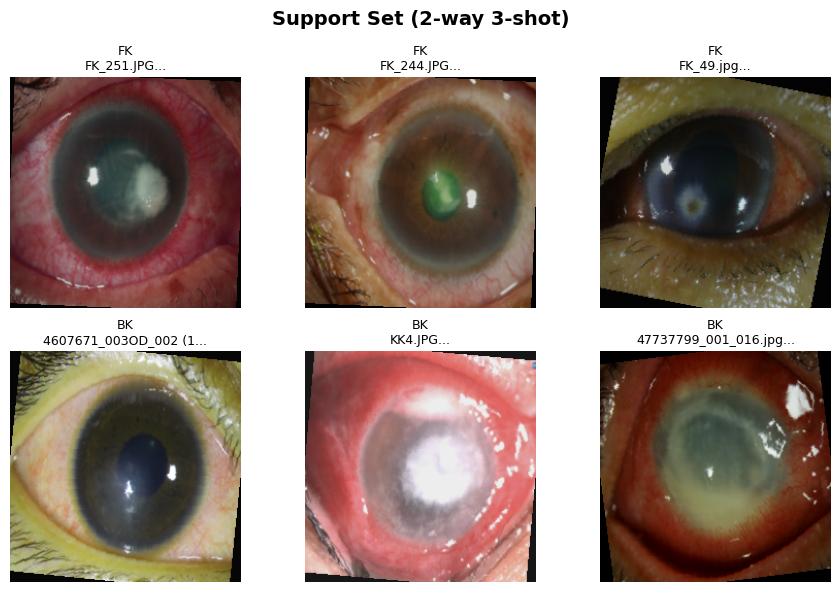

Visualizing Query Set...


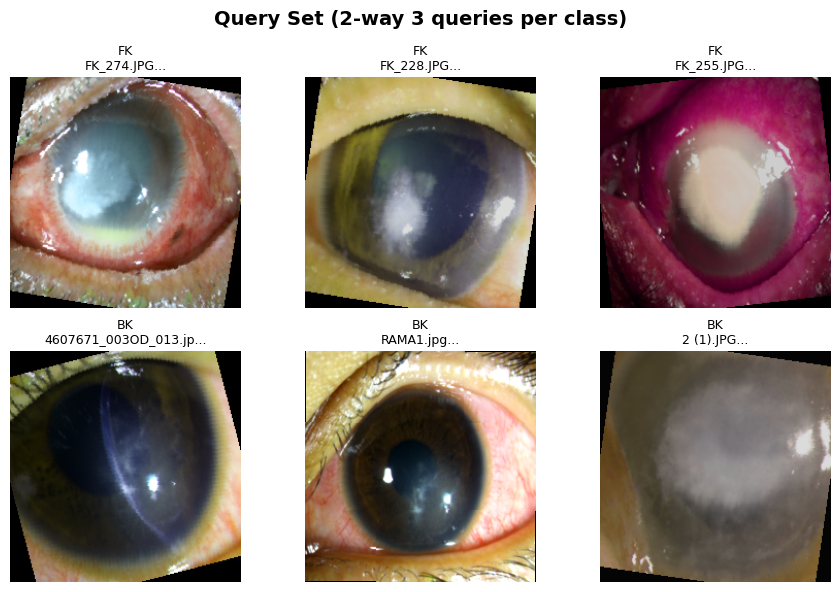

✓ Visualization complete!


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Visualize support set
print("Visualizing Support Set...")
fig, axes = plt.subplots(n_way, k_shot, figsize=(k_shot * 3, n_way * 3))

if n_way == 1:
    axes = axes.reshape(1, -1)

support_idx = 0
for way in range(n_way):
    for shot in range(k_shot):
        # Denormalize image for visualization
        img = image_transforms.denormalize(support_images[support_idx])
        img = img.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[way, shot].imshow(img)
        axes[way, shot].axis('off')
        
        # Add title with label and filename
        filename = os.path.basename(support_paths[support_idx])
        title = f"{support_original_labels[support_idx]}\n{filename[:20]}..."
        axes[way, shot].set_title(title, fontsize=9)
        
        support_idx += 1

plt.suptitle(f'Support Set ({n_way}-way {k_shot}-shot)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize query set
print("Visualizing Query Set...")
fig, axes = plt.subplots(n_way, query_per_class, figsize=(query_per_class * 3, n_way * 3))

if n_way == 1:
    axes = axes.reshape(1, -1)

query_idx = 0
for way in range(n_way):
    for q in range(query_per_class):
        # Denormalize image for visualization
        img = image_transforms.denormalize(query_images[query_idx])
        img = img.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[way, q].imshow(img)
        axes[way, q].axis('off')
        
        # Add title with label and filename
        filename = os.path.basename(query_paths[query_idx])
        title = f"{query_original_labels[query_idx]}\n{filename[:20]}..."
        axes[way, q].set_title(title, fontsize=9)
        
        query_idx += 1

plt.suptitle(f'Query Set ({n_way}-way {query_per_class} queries per class)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

## How to Use the Prototypical Network

### Basic Usage

**1. Create a Model with Default Settings (ResNet50 backbone):**
```python
# Default: ResNet50 backbone with (8, 8) embedding layers
model = PrototypicalNetwork(
    backbone='resnet50',
    embedding_dims=(8, 8),
    pretrained=True,
    cache_dir='../backbones'
)

# Move model to device
model = model.to(device)

# Print model information
model.print_model_info()
```

**2. Try Different Backbones:**
```python
# Vision Transformer
model_vit = PrototypicalNetwork(backbone='vit', embedding_dims=(512, 256, 128))

# DINOv2 (self-supervised)
model_dino = PrototypicalNetwork(backbone='dinov2', embedding_dims=(256, 128))
```

**3. Customize Embedding Layers:**
```python
# Single layer: 2048 → 128
model = PrototypicalNetwork(backbone='resnet50', embedding_dims=(128,))

# Multiple layers: 2048 → 512 → 256 → 128
model = PrototypicalNetwork(backbone='resnet50', embedding_dims=(512, 256, 128))

# No embedding layers (use backbone features directly)
model = PrototypicalNetwork(backbone='resnet50', embedding_dims=())
```

### Available Backbones

| Backbone | Feature Dim | Description |
|----------|-------------|-------------|
| `resnet50` | 2048 | Deep residual network, good for general vision tasks |
| `vit` or `vit_b_16` | 768 | Vision Transformer, captures long-range dependencies |
| `dinov2` or `dinov2_vits14` | 384 | Self-supervised ViT, strong for few-shot learning |

### Forward Pass

**Training/Inference on an Episode:**
```python
# Get support and query images from your episode
support_images = ...  # Shape: (n_way * k_shot, 3, 224, 224)
query_images = ...    # Shape: (n_query, 3, 224, 224)

# Forward pass
logits, prototypes = model(support_images, query_images, n_way=2, k_shot=5)

# logits: (n_query, n_way) - classification scores
# prototypes: (n_way, embedding_dim) - class prototypes

# Get predictions
predictions = torch.argmax(logits, dim=1)
```

### Backbone Freezing

**For faster training or limited data:**
```python
# Freeze backbone (only train embedding layers)
model.freeze_backbone()

# Unfreeze for end-to-end fine-tuning
model.unfreeze_backbone()
```

### Model Storage

All pretrained models are automatically downloaded and cached in the `../backbones/` directory:
- `checkpoints/`: PyTorch Hub model checkpoints
- No need to manually download models
- Models are reused across runs

### Key Methods

**`extract_features(x)`**: Extract embeddings from images
**`compute_prototypes(support_embeddings, n_way, k_shot)`**: Compute class prototypes
**`compute_distances(query_embeddings, prototypes)`**: Calculate distances
**`forward(support_images, query_images, n_way, k_shot)`**: Complete episode processing

### What Happens Inside:

1. **Feature Extraction**: Backbone processes images → feature vectors
2. **Embedding**: FC layers project features → lower-dimensional embeddings
3. **Prototype Computation**: Average support embeddings per class → prototypes
4. **Distance Calculation**: Compute Euclidean distance from queries to prototypes
5. **Classification**: Assign query to nearest prototype

Run the next cell to create and test the model!

In [7]:
from module.model import PrototypicalNetwork

# Create the Prototypical Network
print("Creating Prototypical Network...")
print("This may take a moment as the pretrained model is downloaded...\n")

model = PrototypicalNetwork(
    backbone='resnet50',
    embedding_dims=(256, 64),
    pretrained=True,
    cache_dir='../backbones'
)

model.freeze_backbone()

# Move model to the configured device
model = runtime.to_device(model)

# Print model information
model.print_model_info()

# Test with a sample episode from the loader
print("Testing model with a sample episode...")
model.eval()
with torch.no_grad():
    # Get a test episode
    test_iter = iter(train_loader)
    test_images, test_labels, test_original_labels, test_paths = next(test_iter)
    
    # Move to device
    test_images = test_images.to(device)
    
    # Split into support and query
    support_size = train_sampler.n_way * train_sampler.k_shot
    support_imgs = test_images[:support_size]
    query_imgs = test_images[support_size:]
    
    # Forward pass
    logits, prototypes = model(
        support_imgs, 
        query_imgs, 
        n_way=train_sampler.n_way, 
        k_shot=train_sampler.k_shot
    )
    
    # Get predictions
    predictions = torch.argmax(logits, dim=1)
    
    print(f"\n{'='*70}")
    print("Model Test Results")
    print(f"{'='*70}")
    print(f"Support set shape: {support_imgs.shape}")
    print(f"Query set shape: {query_imgs.shape}")
    print(f"Prototypes shape: {prototypes.shape}")
    print(f"Logits shape: {logits.shape}")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Predictions: {predictions.cpu().numpy()}")
    print(f"{'='*70}\n")

print("✓ Model created and tested successfully!")

Creating Prototypical Network...
This may take a moment as the pretrained model is downloaded...



/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Prototypical Network Architecture
Backbone: resnet50
Backbone Feature Dimension: 2048
Embedding Layer Dimensions: (256, 64)
Final Embedding Dimension: 64
Total Parameters: 24,049,536
Trainable Parameters: 541,504
Backbone Frozen: True

Testing model with a sample episode...

Model Test Results
Support set shape: torch.Size([6, 3, 224, 224])
Query set shape: torch.Size([6, 3, 224, 224])
Prototypes shape: torch.Size([2, 64])
Logits shape: torch.Size([6, 2])
Predictions shape: torch.Size([6])
Predictions: [1 1 1 1 0 1]

✓ Model created and tested successfully!


In [8]:
# ==========================================================================
# FIX: Label-Prototype Misalignment in Episode-Based Training
# ==========================================================================
# The prototypical network assigns local indices (0, 1, ...) to prototypes
# based on the ORDER classes appear in the support set. But the loss was
# comparing these local indices against the dataset's GLOBAL label encoding.
# When classes are sampled in reversed order (e.g. [FK, BK] instead of
# [BK, FK]), ~50% of labels are wrong → training signal cancels out → ~50% acc.
#
# Fix: remap query labels from global → local episode indices before loss.
# ==========================================================================

from torch.utils.data import DataLoader
from module.trainer import PrototypicalNetworkTrainer
from module.evaluator import ModelEvaluator
import torch.nn.functional as F
import os

def _remap_labels(labels, n_way, k_shot):
    """Remap global dataset labels to local episode indices (0, 1, ..., n_way-1).
    
    Support set is ordered: k_shot of class_A, k_shot of class_B, ...
    So support_labels[0] belongs to local class 0, support_labels[k_shot] to local class 1, etc.
    """
    support_size = n_way * k_shot
    support_labels = labels[:support_size]
    
    # Build mapping: global_label → local_index
    local_map = {}
    for way_idx in range(n_way):
        global_label = support_labels[way_idx * k_shot].item()
        local_map[global_label] = way_idx
    
    # Remap all labels (support + query) to local indices
    remapped = torch.tensor([local_map[l.item()] for l in labels],
                            dtype=labels.dtype, device=labels.device)
    return remapped


# --- Patch trainer._train_epoch ---
def _patched_train_epoch(self) -> float:
    self.model.train()
    epoch_loss = 0.0
    train_loader = DataLoader(
        self.train_dataset,
        batch_sampler=self.train_sampler,
        collate_fn=self.collate_fn
    )
    for episode_idx, (images, labels, _, _) in enumerate(train_loader):
        images = images.to(self.device)
        labels = labels.to(self.device)

        # Remap global labels → local episode indices
        labels = _remap_labels(labels, self.n_way, self.k_shot)

        support_size = self.n_way * self.k_shot
        support_images = images[:support_size]
        query_images = images[support_size:]
        query_labels = labels[support_size:]

        self.optimizer.zero_grad()
        logits, _ = self.model(support_images, query_images,
                               self.n_way, self.k_shot)
        loss = self.criterion(logits, query_labels)
        loss.backward()
        self.optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


# --- Patch trainer._validate_epoch ---
def _patched_validate_epoch(self) -> float:
    self.model.eval()
    epoch_loss = 0.0
    val_loader = DataLoader(
        self.val_dataset,
        batch_sampler=self.val_sampler,
        collate_fn=self.collate_fn
    )
    with torch.no_grad():
        for episode_idx, (images, labels, _, _) in enumerate(val_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Remap global labels → local episode indices
            labels = _remap_labels(labels, self.n_way, self.k_shot)

            support_size = self.n_way * self.k_shot
            support_images = images[:support_size]
            query_images = images[support_size:]
            query_labels = labels[support_size:]

            logits, _ = self.model(support_images, query_images,
                                   self.n_way, self.k_shot)
            loss = self.criterion(logits, query_labels)
            epoch_loss += loss.item()

    return epoch_loss / len(val_loader)


# --- Patch evaluator.evaluate ---
_original_evaluate = ModelEvaluator.evaluate

def _patched_evaluate(self, verbose=True):
    print(f"\n{'='*70}")
    print("Starting Model Evaluation on Test Data")
    print(f"{'='*70}")
    print(f"Configuration:")
    print(f"  Test Episodes: {self.max_episode}")
    print(f"  N-way: {self.n_way}, K-shot: {self.k_shot}, Query per class: {self.query_per_class}")
    print(f"  Device: {self.device}")
    print(f"{'='*70}\n")

    self.model.eval()
    test_loader = DataLoader(
        self.test_dataset,
        batch_sampler=self.test_sampler,
        collate_fn=self.collate_fn
    )

    with torch.no_grad():
        for episode_idx, (images, labels, original_labels, paths) in enumerate(test_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)

            # Remap global labels → local episode indices
            remapped = _remap_labels(labels, self.n_way, self.k_shot)

            support_size = self.n_way * self.k_shot
            support_images = images[:support_size]
            query_images = images[support_size:]
            query_labels = remapped[support_size:]
            query_original_labels = original_labels[support_size:]
            query_paths = paths[support_size:]

            logits, _ = self.model(support_images, query_images,
                                   self.n_way, self.k_shot)

            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            pred_probs = probabilities.gather(1, predictions.unsqueeze(1)).squeeze(1)

            query_labels_cpu = query_labels.cpu().numpy()
            predictions_cpu = predictions.cpu().numpy()
            pred_probs_cpu = pred_probs.cpu().numpy()
            probabilities_cpu = probabilities.cpu().numpy()

            for i in range(len(query_labels_cpu)):
                true_label = query_labels_cpu[i]
                pred_label = predictions_cpu[i]
                pred_score = pred_probs_cpu[i]
                file_name = os.path.basename(query_paths[i])

                self._update_confusion_matrix(true_label, pred_label)
                error_type = self._get_error_type(true_label, pred_label)

                self.predictions.append({
                    'episode_id': episode_idx + 1,
                    'file_name': file_name,
                    'prediction_score': pred_score,
                    'class_label': query_original_labels[i],
                    'predicted_label': self.test_dataset.decode_label(pred_label),
                    'error_type': error_type
                })

                self.true_labels.append(true_label)
                self.pred_labels.append(pred_label)
                if self.n_way == 2:
                    self.pred_scores.append(probabilities_cpu[i, 1])
                else:
                    self.pred_scores.append(pred_score)

            if verbose and (episode_idx + 1) % 10 == 0:
                print(f"Processed {episode_idx + 1}/{self.max_episode} episodes...")

    print(f"\n✓ Completed evaluation on {self.max_episode} episodes")
    print(f"✓ Total query samples evaluated: {len(self.predictions)}\n")

    metrics = self._compute_metrics()
    self._save_predictions()
    if self.n_way == 2:
        self._plot_roc_curve()
    self._print_metrics_report(metrics)
    return metrics


# Apply patches
PrototypicalNetworkTrainer._train_epoch = _patched_train_epoch
PrototypicalNetworkTrainer._validate_epoch = _patched_validate_epoch
ModelEvaluator.evaluate = _patched_evaluate

print("✓ Patched PrototypicalNetworkTrainer._train_epoch")
print("✓ Patched PrototypicalNetworkTrainer._validate_epoch")
print("✓ Patched ModelEvaluator.evaluate")
print("✓ Labels will now be remapped to local episode indices")

✓ Patched PrototypicalNetworkTrainer._train_epoch
✓ Patched PrototypicalNetworkTrainer._validate_epoch
✓ Patched ModelEvaluator.evaluate
✓ Labels will now be remapped to local episode indices


Freezing backbone weights...
✓ Backbone parameters: 23,508,032 (all frozen)
✓ Trainable embedding parameters: 541,504
✓ Total trainable parameters: 541,504

Starting training...
This will take some time depending on your hardware and configuration.


Starting Episode-Based Training
Configuration:
  Max Epochs: 100
  Episodes per Epoch: 10
  N-way: 2, K-shot: 4
  Query per class (train): 8
  Query per class (val): 2
  Learning Rate: 0.001
  Early Stopping Patience: 20
  Device: mps

Epoch [  1/100] | Train Loss: 0.2170 | Val Loss: 0.7078 | Time: 51.65s✓ Model checkpoint saved to: ../models/resnet50.pth
 ✓ [Best Model]
Epoch [  2/100] | Train Loss: 0.1484 | Val Loss: 0.7594 | Time: 50.59s (No improvement: 1/20)
Epoch [  3/100] | Train Loss: 0.1752 | Val Loss: 0.8351 | Time: 49.45s (No improvement: 2/20)
Epoch [  4/100] | Train Loss: 0.1784 | Val Loss: 0.7021 | Time: 46.81s✓ Model checkpoint saved to: ../models/resnet50.pth
 ✓ [Best Model]
Epoch [  5/100] | Train Loss: 0.1750 | Val Loss: 

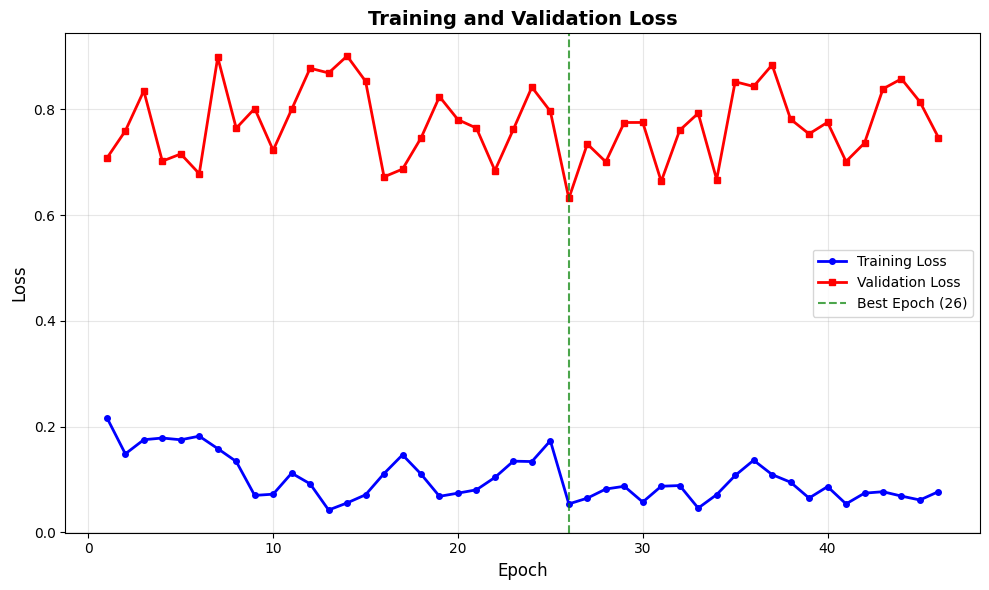

In [ ]:
from module.trainer import PrototypicalNetworkTrainer
# Freeze the backbone to preserve pretrained weights
# Only the embedding layers will be trained
print("=" * 70)
print("Freezing backbone weights...")
print("=" * 70)

# model.unfreeze_backbone()

# Verify backbone is frozen
backbone_params = sum(p.numel() for p in model.backbone.parameters())
backbone_trainable = sum(p.numel() for p in model.backbone.parameters() if p.requires_grad)
embedding_trainable = sum(p.numel() for p in model.embedding.parameters() if p.requires_grad)

print(f"✓ Backbone parameters: {backbone_params:,} (all frozen)")
print(f"✓ Trainable embedding parameters: {embedding_trainable:,}")
print(f"✓ Total trainable parameters: {backbone_trainable + embedding_trainable:,}\n")

# Create the trainer
trainer = PrototypicalNetworkTrainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    n_way=2,
    k_shot=4,
    query_per_class_train=4,  # More queries for training (larger dataset)
    query_per_class_val=2,    # Fewer queries for validation (smaller dataset)
    max_epoch=100,
    max_episode=100,  # Start with smaller number for testing
    learning_rate=0.001,
    patience=20,
    checkpoint_dir='../models',
    log_dir='../logs'
)

# Start training
print("Starting training...")
print("This will take some time depending on your hardware and configuration.\n")

history = trainer.train(verbose=True)

STEP 1: Load Best Model Checkpoint
✓ Loaded checkpoint from epoch 26
✓ Validation loss: 0.6316
✓ Loaded best model checkpoint from ../models

STEP 2: Create Model Evaluator
✓ ModelEvaluator initialized with 100 test episodes

STEP 3: Run Evaluation

Starting Model Evaluation on Test Data
Configuration:
  Test Episodes: 100
  N-way: 2, K-shot: 5, Query per class: 1
  Device: mps

Processed 10/100 episodes...
Processed 20/100 episodes...
Processed 30/100 episodes...
Processed 40/100 episodes...
Processed 50/100 episodes...
Processed 60/100 episodes...
Processed 70/100 episodes...
Processed 80/100 episodes...
Processed 90/100 episodes...
Processed 100/100 episodes...

✓ Completed evaluation on 100 episodes
✓ Total query samples evaluated: 200

✓ Predictions saved to: ../results/resnet50_predictions.csv
✓ ROC curve saved to: ../plots/resnet50_roc_curve.svg


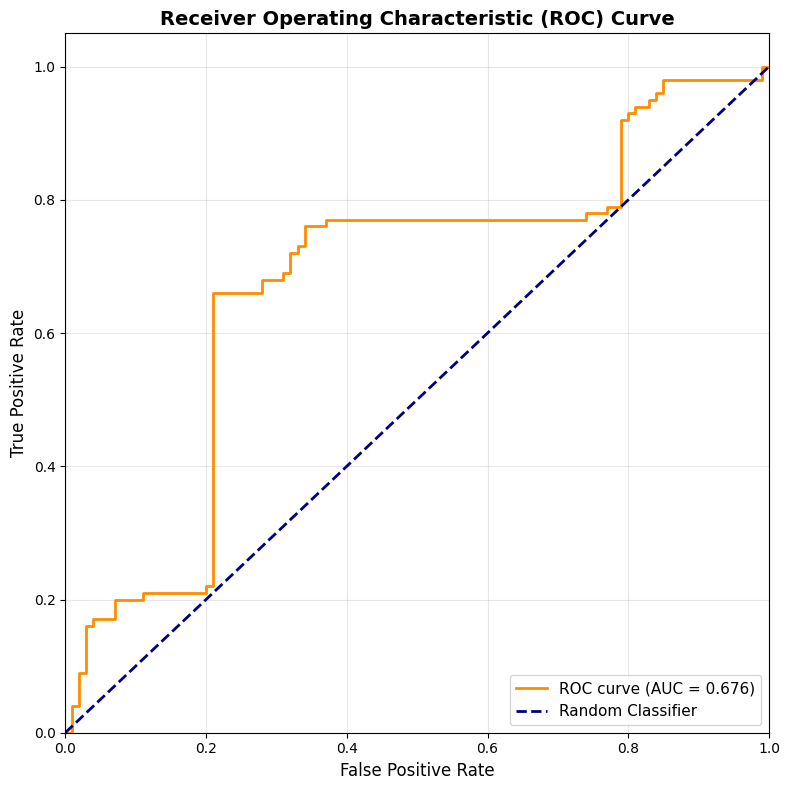


Evaluation Metrics Report

Confusion Matrix:
  TP (True Positive):    69
  FP (False Positive):   31
  TN (True Negative):    69
  FN (False Negative):   31
  Total Samples:        200

Classification Metrics (95% Confidence Interval):
----------------------------------------------------------------------
  Precision   : 0.690 (0.594, 0.772)
  Recall      : 0.690 (0.594, 0.772)
  Accuracy    : 0.690 (0.623, 0.750)
  F1 Score    : 0.690 (0.623, 0.750)



EVALUATION COMPLETE!
✓ Predictions CSV: ../results/resnet50_predictions.csv
✓ ROC Curve SVG:   ../plots/resnet50_roc_curve.svg


In [ ]:
from module.evaluator import ModelEvaluator

# ======================================================================
# EVALUATE TRAINED MODEL ON TEST DATA
# ======================================================================

print("=" * 70)
print("STEP 1: Load Best Model Checkpoint")
print("=" * 70)

# Load best model weights from training
trainer.load_checkpoint()
print(f"✓ Loaded best model checkpoint from {trainer.checkpoint_dir}\n")

print("=" * 70)
print("STEP 2: Create Model Evaluator")
print("=" * 70)

# Initialize evaluator with same configuration as training
evaluator = ModelEvaluator(
    model=model,
    test_dataset=test_dataset,
    device=device,
    n_way=2,
    k_shot=4,
    query_per_class=2,
    max_episode=100,                # Number of test episodes to run
    results_dir='../results',
    plots_dir='../plots'
)
print("✓ ModelEvaluator initialized with 100 test episodes\n")

print("=" * 70)
print("STEP 3: Run Evaluation")
print("=" * 70)

# Evaluate model on test data
metrics = evaluator.evaluate(verbose=True)

print("\n" + "=" * 70)
print("EVALUATION COMPLETE!")
print("=" * 70)
print(f"✓ Predictions CSV: ../results/{model.backbone_name}_predictions.csv")
print(f"✓ ROC Curve SVG:   ../plots/{model.backbone_name}_roc_curve.svg")
print("=" * 70)

In [ ]:
# End eval

In [ ]:
# 512 256
# ======================================================================
# Evaluation Metrics Report
# ======================================================================

# Confusion Matrix:
#   TP (True Positive):    43
#   FP (False Positive):   55
#   TN (True Negative):    45
#   FN (False Negative):   57
#   Total Samples:        200

# Classification Metrics (95% Confidence Interval):
# ----------------------------------------------------------------------
#   Precision   : 0.439 (0.345, 0.537)
#   Recall      : 0.430 (0.337, 0.528)
#   Accuracy    : 0.440 (0.373, 0.509)
#   F1 Score    : 0.434 (0.368, 0.504)

# ======================================================================

# 32 16 16
# ======================================================================
# EVALUATION COMPLETE!
# ======================================================================
# ✓ Predictions CSV: ../results/resnet50_predictions.csv
# ✓ ROC Curve SVG:   ../plots/resnet50_roc_curve.svg
# ======================================================================


# ======================================================================
# Evaluation Metrics Report
# ======================================================================

# Confusion Matrix:
#   TP (True Positive):    53
#   FP (False Positive):   46
#   TN (True Negative):    54
#   FN (False Negative):   47
#   Total Samples:        200

# Classification Metrics (95% Confidence Interval):
# ----------------------------------------------------------------------
#   Precision   : 0.535 (0.438, 0.630)
#   Recall      : 0.530 (0.433, 0.625)
#   Accuracy    : 0.535 (0.466, 0.603)
#   F1 Score    : 0.533 (0.464, 0.601)

# ======================================================================


# ======================================================================
# EVALUATION COMPLETE!
# ======================================================================
# ✓ Predictions CSV: ../results/resnet50_predictions.csv
# ✓ ROC Curve SVG:   ../plots/resnet50_roc_curve.svg
# ======================================================================


# ======================================================================
# Evaluation Metrics Report 8 8 8 8
# ======================================================================

# Confusion Matrix:
#   TP (True Positive):    44
#   FP (False Positive):   45
#   TN (True Negative):    55
#   FN (False Negative):   56
#   Total Samples:        200

# Classification Metrics (95% Confidence Interval):
# ----------------------------------------------------------------------
#   Precision   : 0.494 (0.393, 0.596)
#   Recall      : 0.440 (0.347, 0.538)
#   Accuracy    : 0.495 (0.426, 0.564)
#   F1 Score    : 0.466 (0.398, 0.535)

# ======================================================================


# ======================================================================
# EVALUATION COMPLETE!
# ======================================================================
# ✓ Predictions CSV: ../results/resnet50_predictions.csv
# ✓ ROC Curve SVG:   ../plots/resnet50_roc_curve.svg
# ======================================================================

# Section 7: Analysis of Error - Embedding Space Visualization

## Overview
Understanding how the model makes predictions is crucial for debugging and improving few-shot learning systems. This section provides a visual analysis of the embedding space where the model operates.

## Purpose
By visualizing the embedding vectors in 2D space, we can:
- **Understand Model Decisions**: See how the model separates different classes
- **Identify Misclassifications**: Spot which samples are close to the wrong class prototype
- **Analyze Episode Difficulty**: Evaluate how well-separated support sets are
- **Debug Model Behavior**: Understand why certain predictions fail

## Methodology

### 1. Extract Embedding Vectors
For each sample in a test episode (both support and query sets), we extract the **final embedding vector** from the last layer of the PrototypicalNetwork's embedding layers. These high-dimensional vectors capture the learned representation.

### 2. Dimensionality Reduction
We apply **t-SNE (t-Distributed Stochastic Neighbor Embedding)** or **UMAP (Uniform Manifold Approximation and Projection)** to reduce the embedding vectors from high dimensions (e.g., 128D) to 2D for visualization.

### 3. Visualization Components

**Support Set:**
- **Markers**: Square shape (■)
- **Colors**: 
  - Blue for BK class
  - Orange for FK class
- **Centroids**: Plus sign (+) markers
  - Blue + for BK prototype
  - Orange + for FK prototype

**Query Set:**
- **Markers**: Circle shape (●)
- **Colors**: Based on **predicted class** (not true class)
  - Blue for queries predicted as BK
  - Orange for queries predicted as FK
- **Labels**: Filename shown next to each marker
- **Jittering**: Applied when markers overlap to improve readability

### 4. Per-Episode Plots
Each test episode gets its own 2D scatter plot showing:
- Where support samples are embedded
- Where the class prototypes (centroids) are located
- Where query samples are embedded
- Which class each query was predicted to belong to

## Output Files
For each episode analyzed, a plot is saved to `../plots/` with filename format:
- `{backbone_name}_episode_{episode_id}.svg`
- Example: `resnet50_episode_1.svg`, `resnet50_episode_2.svg`, etc.

## Interpretation Guide

**Good Predictions:**
- Query circles cluster near the correct prototype (+)
- Support squares of same class are tightly grouped
- Clear separation between blue and orange regions

**Misclassifications:**
- Query circle appears near the wrong prototype
- Indicates ambiguous embedding or difficult sample
- Check filename label to identify problematic images

**Difficult Episodes:**
- Support sets overlap or are poorly separated
- Prototypes (+) are close together
- Indicates challenging few-shot learning scenario

In [ ]:
# Load model

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from adjustText import adjust_text
import numpy as np


class EmbeddingVisualizer:
    """
    Visualizer for analyzing model predictions through embedding space visualization.
    
    Creates 2D scatter plots showing support sets, prototypes, and query predictions
    for each episode to understand model behavior and identify errors.
    """
    
    def __init__(self, model: PrototypicalNetwork, test_dataset: ImageDataset,
                 device: torch.device, n_way: int = 2, k_shot: int = 5,
                 query_per_class: int = 5, max_episode: int = 10,
                 plots_dir: str = '../plots', reduction_method: str = 'tsne',
                 jitter_strength: float = 0.02, random_state: int = 42):
        """
        Initialize the embedding visualizer.
        
        Args:
            model: Trained PrototypicalNetwork instance
            test_dataset: Test dataset
            device: Device to run on
            n_way: Number of classes per episode
            k_shot: Number of support examples per class
            query_per_class: Number of query examples per class
            max_episode: Number of episodes to visualize
            plots_dir: Directory to save plots
            reduction_method: Dimensionality reduction method ('tsne' or 'umap')
            jitter_strength: Amount of random jitter to apply (0.0 to 0.1)
            random_state: Random seed for reproducibility
        """
        self.model = model
        self.test_dataset = test_dataset
        self.device = device
        
        self.n_way = n_way
        self.k_shot = k_shot
        self.query_per_class = query_per_class
        self.max_episode = max_episode
        
        self.plots_dir = Path(plots_dir)
        self.plots_dir.mkdir(parents=True, exist_ok=True)
        
        self.reduction_method = reduction_method.lower()
        self.jitter_strength = jitter_strength
        self.random_state = random_state
        
        # Color scheme
        self.class_colors = {0: '#1f77b4', 1: '#ff7f0e'}  # Blue for BK, Orange for FK
        self.class_names = {0: 'BK', 1: 'FK'}
        
    def _extract_embeddings(self, images: torch.Tensor) -> torch.Tensor:
        """
        Extract final embedding vectors from the model.
        
        Args:
            images: Input images tensor (batch_size, 3, H, W)
            
        Returns:
            Embedding vectors (batch_size, embedding_dim)
        """
        self.model.eval()
        with torch.no_grad():
            # Pass through backbone
            features = self.model.backbone(images)
            
            # Pass through embedding layers
            embeddings = self.model.embedding(features)
            
        return embeddings
    
    def _reduce_dimensions(self, embeddings: np.ndarray) -> np.ndarray:
        """
        Reduce embeddings to 2D using t-SNE or UMAP.
        
        Args:
            embeddings: High-dimensional embeddings (n_samples, embedding_dim)
            
        Returns:
            2D coordinates (n_samples, 2)
        """
        if self.reduction_method == 'tsne':
            reducer = TSNE(
                n_components=2,
                random_state=self.random_state,
                perplexity=min(30, embeddings.shape[0] - 1),
                n_iter=1000
            )
        elif self.reduction_method == 'umap':
            try:
                from umap import UMAP
                reducer = UMAP(
                    n_components=2,
                    random_state=self.random_state,
                    n_neighbors=min(15, embeddings.shape[0] - 1)
                )
            except ImportError:
                print("⚠ UMAP not installed. Falling back to t-SNE.")
                print("  Install with: pip install umap-learn")
                reducer = TSNE(
                    n_components=2,
                    random_state=self.random_state,
                    perplexity=min(30, embeddings.shape[0] - 1)
                )
        else:
            raise ValueError(f"Unknown reduction method: {self.reduction_method}")
        
        coords_2d = reducer.fit_transform(embeddings)
        return coords_2d
    
    def _apply_jitter(self, coords: np.ndarray) -> np.ndarray:
        """
        Apply random jitter to coordinates to prevent overlapping markers.
        
        Args:
            coords: 2D coordinates (n_samples, 2)
            
        Returns:
            Jittered coordinates
        """
        np.random.seed(self.random_state)
        jitter = np.random.randn(*coords.shape) * self.jitter_strength
        return coords + jitter
    
    def _plot_episode(self, episode_id: int, support_coords: np.ndarray,
                     query_coords: np.ndarray, prototype_coords: np.ndarray,
                     support_labels: np.ndarray, query_labels: np.ndarray,
                     query_predictions: np.ndarray, support_indices: list,
                     query_indices: list) -> None:
        """
        Create and save a scatter plot for one episode.
        
        Args:
            episode_id: Episode number
            support_coords: 2D coords for support samples (n_support, 2)
            query_coords: 2D coords for query samples (n_query, 2)
            prototype_coords: 2D coords for prototypes (n_way, 2)
            support_labels: True labels for support (n_support,)
            query_labels: True labels for query (n_query,)
            query_predictions: Predicted labels for query (n_query,)
            support_indices: Dataset indices for support samples
            query_indices: Dataset indices for query samples
        """
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Apply jitter to all coordinates
        support_coords = self._apply_jitter(support_coords)
        query_coords = self._apply_jitter(query_coords)
        
        # Plot support set (squares)
        for class_idx in range(self.n_way):
            mask = support_labels == class_idx
            if np.any(mask):
                ax.scatter(
                    support_coords[mask, 0],
                    support_coords[mask, 1],
                    c=self.class_colors[class_idx],
                    marker='s',
                    s=200,
                    alpha=0.7,
                    edgecolors='black',
                    linewidths=2,
                    label=f'{self.class_names[class_idx]} Support'
                )
        
        # Plot prototypes (plus signs) - use smaller markers for legend
        for class_idx in range(self.n_way):
            ax.scatter(
                prototype_coords[class_idx, 0],
                prototype_coords[class_idx, 1],
                c=self.class_colors[class_idx],
                marker='P',
                s=300,  # Reduced from 500 for better legend spacing
                edgecolors='black',
                linewidths=2,  # Reduced from 3
                label=f'{self.class_names[class_idx]} Centroid',
                zorder=10
            )
        
        # Plot query set (circles, colored by prediction)
        for class_idx in range(self.n_way):
            mask = query_predictions == class_idx
            if np.any(mask):
                ax.scatter(
                    query_coords[mask, 0],
                    query_coords[mask, 1],
                    c=self.class_colors[class_idx],
                    marker='o',
                    s=150,
                    alpha=0.8,
                    edgecolors='black',
                    linewidths=1.5,
                    label=f'Predicted as {self.class_names[class_idx]}'
                )
        
        # Add sample ID labels for support set (above the markers with offset)
        texts = []
        y_offset = 0.02 * (np.max(support_coords[:, 1]) - np.min(support_coords[:, 1]))  # 2% of y-range
        for i, (x, y) in enumerate(support_coords):
            sample_id = support_indices[i] + 1  # Row number starts from 1 (row 0 is header)
            # Position label above the marker with vertical offset
            texts.append(ax.text(x, y + y_offset, f'S{sample_id}', fontsize=9, ha='center', va='bottom',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                       edgecolor='gray', alpha=0.8, linewidth=0.5),
                               fontweight='bold'))
        
        # Add sample ID labels for query set (above the markers with offset)
        for i, (x, y) in enumerate(query_coords):
            sample_id = query_indices[i] + 1  # Row number starts from 1 (row 0 is header)
            # Mark misclassifications with asterisk
            true_label = query_labels[i]
            pred_label = query_predictions[i]
            marker = '*' if true_label != pred_label else ''
            # Get true class name
            true_class_name = self.class_names[true_label]
            # Position label above the marker with vertical offset
            label_text = f'Q{sample_id} ({true_class_name}){marker}'
            texts.append(ax.text(x, y + y_offset, label_text, fontsize=9, 
                               ha='center', va='bottom',
                               color='red' if marker else 'black',
                               bbox=dict(boxstyle='round,pad=0.3', 
                                       facecolor='white', 
                                       edgecolor='red' if marker else 'gray', 
                                       alpha=0.9 if marker else 0.8,
                                       linewidth=1.0 if marker else 0.5),
                               fontweight='bold'))
        
        # Adjust text positions to avoid overlap
        try:
            adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
        except:
            # If adjust_text fails, continue without adjustment
            pass
        
        # Formatting
        ax.set_xlabel('Dimension 1', fontsize=12, fontweight='bold')
        ax.set_ylabel('Dimension 2', fontsize=12, fontweight='bold')
        ax.set_title(
            f'Episode {episode_id}: Embedding Space Visualization '
            f'({self.reduction_method.upper()})\n'
            f'{self.n_way}-way {self.k_shot}-shot | '
            f'Backbone: {self.model.backbone_name}',
            fontsize=14,
            fontweight='bold',
            pad=20
        )
        
        # Create a better legend for manuscript with proper spacing
        ax.legend(
            loc='upper right',
            bbox_to_anchor=(1.0, 1.0),
            fontsize=10,
            frameon=True,
            framealpha=0.95,
            edgecolor='black',
            fancybox=True,
            shadow=True,
            ncol=1,
            columnspacing=2.0,
            labelspacing=1.5,        # Even more spacing between entries
            handletextpad=1.2,       # More space between marker and text
            handlelength=3.0,        # Longer marker line
            borderpad=1.5,           # More padding inside legend box
            markerscale=0.8          # Slightly smaller markers in legend
        )
        
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add note about labels and misclassifications
        error_count = np.sum(query_labels != query_predictions)
        note = (f'Labels: S=Support, Q=Query (sample ID from test.csv)\n'
                f'* indicates misclassification ({error_count}/{len(query_labels)} errors)')
        ax.text(0.02, 0.02, note, transform=ax.transAxes, 
               fontsize=9, verticalalignment='bottom',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7, edgecolor='black', linewidth=1))
        
        plt.tight_layout()
        
        # Save plot
        filename = f"{self.model.backbone_name}_episode_{episode_id}.svg"
        filepath = self.plots_dir / filename
        plt.savefig(filepath, format='svg', dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ Saved episode {episode_id} plot: {filepath}")
    
    def visualize(self, verbose: bool = True) -> None:
        """
        Generate embedding visualizations for multiple test episodes.
        
        Args:
            verbose: Whether to print progress information
        """
        if verbose:
            print("=" * 70)
            print("Starting Embedding Space Visualization")
            print("=" * 70)
            print(f"Configuration:")
            print(f"  Episodes to visualize: {self.max_episode}")
            print(f"  N-way: {self.n_way}, K-shot: {self.k_shot}, Query per class: {self.query_per_class}")
            print(f"  Reduction method: {self.reduction_method.upper()}")
            print(f"  Device: {self.device}")
            print(f"  Output directory: {self.plots_dir}")
            print("=" * 70)
        
        self.model.eval()
        
        # Build class-to-indices mapping
        class_to_indices = {}
        for idx in range(len(self.test_dataset)):
            _, label, _, _ = self.test_dataset[idx]
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(idx)
        
        classes = list(class_to_indices.keys())
        
        # Validate
        if len(classes) < self.n_way:
            raise ValueError(f"Test dataset has {len(classes)} classes but n_way={self.n_way}")
        
        for episode_id in range(1, self.max_episode + 1):
            if verbose:
                print(f"\nProcessing Episode {episode_id}/{self.max_episode}...")
            
            # Manually sample episode
            # Randomly select N classes for this episode
            selected_classes = np.random.choice(classes, self.n_way, replace=False)
            
            support_indices = []
            query_indices = []
            
            for cls in selected_classes:
                # Get all indices for this class
                cls_indices = class_to_indices[cls].copy()
                
                # Randomly sample K+Q indices from this class
                sampled_indices = np.random.choice(
                    cls_indices,
                    self.k_shot + self.query_per_class,
                    replace=False
                )
                
                # First K samples are support, rest are query
                support_indices.extend(sampled_indices[:self.k_shot])
                query_indices.extend(sampled_indices[self.k_shot:])
            
            # Get data
            support_data = [self.test_dataset[i] for i in support_indices]
            query_data = [self.test_dataset[i] for i in query_indices]
            
            support_images = torch.stack([x[0] for x in support_data]).to(self.device)
            support_labels = torch.tensor([x[1] for x in support_data])
            support_filenames = [x[2] for x in support_data]
            
            query_images = torch.stack([x[0] for x in query_data]).to(self.device)
            query_labels = torch.tensor([x[1] for x in query_data])
            query_filenames = [x[2] for x in query_data]
            
            # Extract embeddings
            support_embeddings = self._extract_embeddings(support_images)
            query_embeddings = self._extract_embeddings(query_images)
            
            # Compute prototypes in high-dimensional space (for predictions)
            support_embeddings_reshaped = support_embeddings.view(
                self.n_way, self.k_shot, -1
            )
            prototypes = support_embeddings_reshaped.mean(dim=1)  # (n_way, embedding_dim)
            
            # Get predictions
            with torch.no_grad():
                dists = torch.cdist(query_embeddings, prototypes)  # (n_query, n_way)
                query_predictions = torch.argmin(dists, dim=1)
            
            # Combine support and query embeddings for dimensionality reduction
            # NOTE: We reduce only support and query, then compute centroids in 2D space
            all_embeddings = torch.cat([
                support_embeddings,
                query_embeddings
            ], dim=0).cpu().numpy()
            
            # Reduce to 2D
            coords_2d = self._reduce_dimensions(all_embeddings)
            
            # Split back into components
            n_support = len(support_embeddings)
            n_query = len(query_embeddings)
            
            support_coords = coords_2d[:n_support]
            query_coords = coords_2d[n_support:n_support + n_query]
            
            # Compute prototype coordinates in 2D space from reduced support coordinates
            support_coords_reshaped = support_coords.reshape(self.n_way, self.k_shot, 2)
            prototype_coords = support_coords_reshaped.mean(axis=1)  # (n_way, 2)
            
            # Create plot
            self._plot_episode(
                episode_id=episode_id,
                support_coords=support_coords,
                query_coords=query_coords,
                prototype_coords=prototype_coords,
                support_labels=support_labels.numpy(),
                query_labels=query_labels.numpy(),
                query_predictions=query_predictions.cpu().numpy(),
                support_indices=support_indices,
                query_indices=query_indices
            )
        
        if verbose:
            print("\n" + "=" * 70)
            print("✓ Visualization Complete!")
            print(f"✓ Generated {self.max_episode} episode plots in {self.plots_dir}")
            print("=" * 70)

In [ ]:
%pip install adjustText


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## How to Use the Embedding Visualizer

### Basic Usage

**1. Create Visualizer Instance:**
```python
visualizer = EmbeddingVisualizer(
    model=model,                  # Your trained model
    test_dataset=test_dataset,    # Test dataset
    device=device,                # Device (CPU/CUDA/MPS)
    n_way=2,                      # Same as training
    k_shot=5,                     # Same as training
    query_per_class=5,            # Same as training
    max_episode=10,               # Number of episodes to visualize
    plots_dir='../plots',         # Where to save plots
    reduction_method='tsne',      # 'tsne' or 'umap'
    jitter_strength=0.02,         # Random jitter to prevent overlap
    random_state=42               # For reproducibility
)
```

**2. Generate Visualizations:**
```python
# Generate plots for all episodes
visualizer.visualize(verbose=True)
```

### Configuration Options

**Dimensionality Reduction Methods:**
- **`'tsne'`** (default): t-Distributed Stochastic Neighbor Embedding
  - Good for visualizing clusters
  - Preserves local structure
  - Slower but widely used
- **`'umap'`**: Uniform Manifold Approximation and Projection
  - Faster than t-SNE
  - Preserves both local and global structure
  - Requires: `pip install umap-learn`

**Jitter Strength:**
- Range: `0.0` to `0.1`
- `0.02` (default): Small random offset to prevent marker overlap
- Increase if markers are still overlapping
- Decrease if you want exact positions

**Number of Episodes:**
- `max_episode=10` (default): Visualize 10 episodes
- Increase for more comprehensive analysis
- Decrease for faster processing

### Understanding the Plots

**Visual Elements:**

| Element | Shape | Color | Meaning |
|---------|-------|-------|---------|
| Support BK | Square (■) | Blue | BK class support samples |
| Support FK | Square (■) | Orange | FK class support samples |
| Prototype BK | Plus (+) | Blue | BK class centroid |
| Prototype FK | Plus (+) | Orange | FK class centroid |
| Query → BK | Circle (●) | Blue | Predicted as BK |
| Query → FK | Circle (●) | Orange | Predicted as FK |

**Filename Labels:**
- Each marker has its filename displayed
- **Asterisk (*)**: Indicates misclassification
- Red text: Misclassified sample
- Black text: Correctly classified sample

**Interpretation:**

✅ **Good Episode (High Accuracy):**
```
- Support squares well-separated by color
- Prototypes (+) far apart
- Query circles cluster near correct prototype
- Few or no asterisks (*)
```

⚠️ **Challenging Episode (Low Accuracy):**
```
- Support squares overlap between classes
- Prototypes (+) close together
- Query circles between both prototypes
- Many asterisks (*) indicating errors
```

🔍 **Misclassification Analysis:**
```
- Red filename with asterisk (*) = wrong prediction
- Check position: Is it near the wrong prototype?
- Check neighbors: Are support samples ambiguous?
- Indicates difficult or mislabeled sample
```

### Output Files

**File Naming Convention:**
```
{backbone_name}_episode_{episode_id}.svg
```

**Examples:**
- `resnet50_episode_1.svg`
- `resnet50_episode_2.svg`
- `dinov2_episode_1.svg`

**File Format:**
- **SVG (Scalable Vector Graphics)**
- High resolution, perfect for papers/presentations
- Can be opened in web browsers or vector editors
- Lossless quality at any zoom level

### Advanced Usage

**Compare Different Reduction Methods:**
```python
# Visualize with t-SNE
visualizer_tsne = EmbeddingVisualizer(
    model=model, test_dataset=test_dataset, device=device,
    reduction_method='tsne', max_episode=5
)
visualizer_tsne.visualize()

# Visualize with UMAP (if installed)
visualizer_umap = EmbeddingVisualizer(
    model=model, test_dataset=test_dataset, device=device,
    reduction_method='umap', max_episode=5
)
visualizer_umap.visualize()
```

**Analyze Specific Episodes:**
```python
# Visualize only the first 3 episodes
visualizer = EmbeddingVisualizer(
    model=model,
    test_dataset=test_dataset,
    device=device,
    max_episode=3
)
visualizer.visualize()
```

**Adjust for Dense Plots:**
```python
# Increase jitter if markers overlap too much
visualizer = EmbeddingVisualizer(
    model=model,
    test_dataset=test_dataset,
    device=device,
    jitter_strength=0.05  # More separation
)
visualizer.visualize()
```

### Troubleshooting

**Issue: "UMAP not installed"**
```bash
# Install UMAP
pip install umap-learn

# Or use t-SNE (default, always available)
visualizer = EmbeddingVisualizer(..., reduction_method='tsne')
```

**Issue: Text labels overlap**
- The `adjust_text` library automatically spreads labels
- Install if needed: `pip install adjustText`
- Or increase `jitter_strength` parameter

**Issue: Plots look cluttered**
- Reduce `max_episode` to visualize fewer episodes
- Increase figure size (requires modifying the class)
- Focus on specific challenging episodes

### What to Look For

**1. Class Separation:**
- Are blue and orange regions distinct?
- Clear separation = model learned good features
- Overlap = difficult classification task

**2. Prototype Position:**
- Prototypes (+) should be centered in their class region
- Distance between prototypes indicates class separability

**3. Query Distribution:**
- Queries should cluster near their true class prototype
- Queries between prototypes = uncertain predictions
- Queries near wrong prototype = systematic errors

**4. Support Quality:**
- Tight support clusters = representative samples
- Scattered support = high intra-class variation
- Mixed support = potentially mislabeled data

**5. Misclassification Patterns:**
- Are errors concentrated in specific regions?
- Do certain filenames repeatedly appear as errors?
- Use this to identify problematic samples or classes

Run the next cell to generate embedding visualizations!

In [ ]:
# ======================================================================
# VISUALIZE EMBEDDING SPACE FOR ERROR ANALYSIS
# ======================================================================

print("=" * 70)
print("STEP 1: Create Embedding Visualizer")
print("=" * 70)

# Initialize visualizer for first 10 test episodes
visualizer = EmbeddingVisualizer(
    model=model,
    test_dataset=test_dataset,
    device=device,
    n_way=n_way,
    k_shot=k_shot,
    query_per_class=query_per_class,
    max_episode=10,                 # Visualize first 10 episodes
    plots_dir='../plots',
    reduction_method='tsne',        # Use t-SNE for dimensionality reduction
    jitter_strength=0.02,           # Small jitter to prevent marker overlap
    random_state=42
)
print("✓ EmbeddingVisualizer initialized for 10 episodes\n")

print("=" * 70)
print("STEP 2: Generate Episode Visualizations")
print("=" * 70)

# Generate all embedding space plots
visualizer.visualize(verbose=True)

print("\n" + "=" * 70)
print("VISUALIZATION COMPLETE!")
print("=" * 70)
print(f"✓ Generated plots for {visualizer.max_episode} episodes")
print(f"✓ Output directory: {visualizer.plots_dir}")
print(f"✓ File format: {model.backbone_name}_episode_{{id}}.svg")
print("=" * 70)
print("\nNext Steps:")
print("  1. Open SVG files in your browser or vector editor")
print("  2. Look for patterns in misclassifications (marked with *)")
print("  3. Identify episodes with poor class separation")
print("  4. Use insights to improve data quality or model architecture")
print("=" * 70)

STEP 1: Create Embedding Visualizer
✓ EmbeddingVisualizer initialized for 10 episodes

STEP 2: Generate Episode Visualizations
Starting Embedding Space Visualization
Configuration:
  Episodes to visualize: 10
  N-way: 2, K-shot: 3, Query per class: 3
  Reduction method: TSNE
  Device: mps
  Output directory: ../plots

Processing Episode 1/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 1 plot: ../plots/resnet50_episode_1.svg

Processing Episode 2/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 2 plot: ../plots/resnet50_episode_2.svg

Processing Episode 3/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 3 plot: ../plots/resnet50_episode_3.svg

Processing Episode 4/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 4 plot: ../plots/resnet50_episode_4.svg

Processing Episode 5/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 5 plot: ../plots/resnet50_episode_5.svg

Processing Episode 6/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 6 plot: ../plots/resnet50_episode_6.svg

Processing Episode 7/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 7 plot: ../plots/resnet50_episode_7.svg

Processing Episode 8/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 8 plot: ../plots/resnet50_episode_8.svg

Processing Episode 9/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 9 plot: ../plots/resnet50_episode_9.svg

Processing Episode 10/10...


/Users/buddy/Documents/Vscode/opthal/src/env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved episode 10 plot: ../plots/resnet50_episode_10.svg

✓ Visualization Complete!
✓ Generated 10 episode plots in ../plots

VISUALIZATION COMPLETE!
✓ Generated plots for 10 episodes
✓ Output directory: ../plots
✓ File format: resnet50_episode_{id}.svg

Next Steps:
  1. Open SVG files in your browser or vector editor
  2. Look for patterns in misclassifications (marked with *)
  3. Identify episodes with poor class separation
  4. Use insights to improve data quality or model architecture


## Validation: Comparing High-Dimensional vs 2D Predictions

Let's verify the dimensionality reduction effect by comparing distances and predictions in both spaces. This function works with any embedding dimension architecture.

In [ ]:
def compare_hd_vs_2d_predictions(model, dataset, episode_idx=0, query_sample_id=None, 
                                  n_way=2, k_shot=3, query_per_class=3, device='cpu', 
                                  random_seed=42):
    """
    Compare model predictions in high-dimensional embedding space vs 2D visualization space.
    
    This function demonstrates how dimensionality reduction (t-SNE/UMAP) can distort distance
    relationships, making predictions appear incorrect in 2D plots even when the model
    predicts correctly in the original high-dimensional space.
    
    Args:
        model: The trained PrototypicalNetwork model
        dataset: The dataset to sample from (typically test_dataset)
        episode_idx: Which episode to analyze (default: 0 for first episode)
        query_sample_id: Specific query sample ID to focus on (None = analyze all)
        n_way: Number of classes per episode
        k_shot: Number of support examples per class
        query_per_class: Number of query examples per class
        device: Device to run inference on
        random_seed: Random seed for reproducibility
        
    Returns:
        Dictionary containing analysis results with distance information
    """
    from sklearn.manifold import TSNE
    import pandas as pd
    
    # Get embedding dimension from model
    embedding_dim = model.final_embedding_dim
    
    print("=" * 80)
    print(f"ANALYSIS: High-Dimensional ({embedding_dim}D) vs 2D Space Comparison")
    print("=" * 80)
    print(f"Episode: {episode_idx + 1} | Embedding Architecture: {model.embedding_dims}")
    print("This demonstrates how dimensionality reduction can distort distance relationships")
    print("=" * 80)
    
    # Set random seed for reproducibility
    np.random.seed(random_seed + episode_idx)
    torch.manual_seed(random_seed + episode_idx)
    
    # Build class-to-indices mapping
    class_to_indices = {}
    for idx in range(len(dataset)):
        _, label, _, _ = dataset[idx]
        if label not in class_to_indices:
            class_to_indices[label] = []
        class_to_indices[label].append(idx)
    
    classes = list(class_to_indices.keys())
    
    # Sample episode
    selected_classes = np.random.choice(classes, n_way, replace=False)
    
    support_indices = []
    query_indices = []
    
    for cls in selected_classes:
        cls_indices = class_to_indices[cls].copy()
        sampled_indices = np.random.choice(
            cls_indices,
            k_shot + query_per_class,
            replace=False
        )
        support_indices.extend(sampled_indices[:k_shot])
        query_indices.extend(sampled_indices[k_shot:])
    
    # Get data
    support_data = [dataset[i] for i in support_indices]
    query_data = [dataset[i] for i in query_indices]
    
    support_images = torch.stack([x[0] for x in support_data]).to(device)
    support_labels = torch.tensor([x[1] for x in support_data])
    query_images = torch.stack([x[0] for x in query_data]).to(device)
    query_labels = torch.tensor([x[1] for x in query_data])
    
    print(f"\nEpisode {episode_idx + 1} Configuration:")
    print(f"  Selected classes: {selected_classes}")
    print(f"  Support indices: {support_indices}")
    print(f"  Query indices: {query_indices}")
    
    # Extract embeddings in high-dimensional space
    model.eval()
    with torch.no_grad():
        support_embeddings_hd = model.extract_features(support_images)
        query_embeddings_hd = model.extract_features(query_images)
    
    # Compute prototypes in high-dimensional space
    support_embeddings_hd_reshaped = support_embeddings_hd.view(n_way, k_shot, -1)
    prototypes_hd = support_embeddings_hd_reshaped.mean(dim=1)
    
    # Get predictions in high-dimensional space (what model actually uses)
    dists_hd = torch.cdist(query_embeddings_hd, prototypes_hd)
    query_predictions_hd = torch.argmin(dists_hd, dim=1)
    
    # Apply dimensionality reduction to 2D
    all_embeddings_hd = torch.cat([
        support_embeddings_hd,
        query_embeddings_hd
    ], dim=0).cpu().numpy()
    
    reducer = TSNE(n_components=2, random_state=random_seed, 
                   perplexity=min(30, all_embeddings_hd.shape[0] - 1))
    coords_2d = reducer.fit_transform(all_embeddings_hd)
    
    # Split back
    n_support = len(support_embeddings_hd)
    n_query = len(query_embeddings_hd)
    
    support_coords_2d = coords_2d[:n_support]
    query_coords_2d = coords_2d[n_support:n_support + n_query]
    
    # Compute prototypes in 2D space
    support_coords_2d_reshaped = support_coords_2d.reshape(n_way, k_shot, 2)
    prototypes_2d = support_coords_2d_reshaped.mean(axis=1)
    
    # Compute distances in 2D space
    dists_2d = np.linalg.norm(
        query_coords_2d[:, np.newaxis, :] - prototypes_2d[np.newaxis, :, :], 
        axis=2
    )
    query_predictions_2d = np.argmin(dists_2d, axis=1)
    
    # Convert class indices to names
    class_names = {0: 'BK', 1: 'FK'}
    
    # Prepare results
    results = {
        'episode_idx': episode_idx,
        'embedding_dim': embedding_dim,
        'selected_classes': selected_classes,
        'query_samples': []
    }
    
    print("\n" + "=" * 80)
    print(f"COMPARISON FOR ALL QUERY SAMPLES (Episode {episode_idx + 1})")
    print("=" * 80)
    
    # Analyze all query samples
    for i in range(len(query_indices)):
        sample_idx = query_indices[i]
        true_label = query_labels[i].item()
        pred_hd = query_predictions_hd[i].item()
        pred_2d = query_predictions_2d[i]
        
        # Get distances in HD space
        dists_to_centroids_hd = {
            class_names[j]: dists_hd[i, j].item() 
            for j in range(n_way)
        }
        
        # Get distances in 2D space
        dists_to_centroids_2d = {
            class_names[j]: dists_2d[i, j] 
            for j in range(n_way)
        }
        
        sample_result = {
            'sample_idx': sample_idx,
            'sample_id': sample_idx + 1,
            'true_label': class_names[true_label],
            'pred_hd': class_names[pred_hd],
            'pred_2d': class_names[pred_2d],
            'dists_hd': dists_to_centroids_hd,
            'dists_2d': dists_to_centroids_2d,
            'correct_hd': pred_hd == true_label,
            'mismatch': pred_hd != pred_2d
        }
        results['query_samples'].append(sample_result)
        
        # Print detailed analysis
        print(f"\n{'─' * 80}")
        print(f"Query Sample #{i+1} (Dataset Index: {sample_idx}, Sample ID: {sample_idx + 1})")
        print(f"{'─' * 80}")
        print(f"  True Label: {class_names[true_label]}")
        print(f"\n  HIGH-DIMENSIONAL ({embedding_dim}D) SPACE - Where Model Actually Predicts:")
        for cls_name, dist in dists_to_centroids_hd.items():
            print(f"    Distance to {cls_name} centroid: {dist:.6f}")
        print(f"    Predicted Label: {class_names[pred_hd]} {'✓ CORRECT' if pred_hd == true_label else '✗ WRONG'}")
        print(f"\n  2D VISUALIZATION SPACE - What You See in Plot:")
        for cls_name, dist in dists_to_centroids_2d.items():
            print(f"    Distance to {cls_name} centroid: {dist:.6f}")
        print(f"    Visual Prediction: {class_names[pred_2d]} {'(matches HD)' if pred_2d == pred_hd else '(DIFFERENT from HD!)'}")
        
        # Highlight discrepancies
        if pred_hd != pred_2d:
            print(f"\n  ⚠️  WARNING: Dimensionality reduction changed the nearest centroid!")
            print(f"      In {embedding_dim}D: closer to {class_names[pred_hd]}")
            print(f"      In 2D: closer to {class_names[pred_2d]}")
    
    # Focus on specific query sample if requested
    if query_sample_id is not None:
        print("\n" + "=" * 80)
        print(f"FOCUS ON SAMPLE ID {query_sample_id}")
        print("=" * 80)
        
        # Find the sample in query list
        target_idx = None
        for i, idx in enumerate(query_indices):
            if idx + 1 == query_sample_id:
                target_idx = i
                break
        
        if target_idx is not None:
            sample_result = results['query_samples'][target_idx]
            
            print(f"\n📍 Sample ID {query_sample_id} Analysis:")
            print(f"   True Label: {sample_result['true_label']}")
            print(f"\n   In {embedding_dim}D Space (Model's Decision):")
            for cls_name, dist in sample_result['dists_hd'].items():
                print(f"     • Distance to {cls_name}: {dist:.6f}")
            print(f"     • Closer to: {sample_result['pred_hd']}")
            print(f"     • Model predicts: {sample_result['pred_hd']} {'✓' if sample_result['correct_hd'] else '✗'}")
            print(f"\n   In 2D Space (What Plot Shows):")
            for cls_name, dist in sample_result['dists_2d'].items():
                print(f"     • Distance to {cls_name}: {dist:.6f}")
            print(f"     • Visually closer to: {sample_result['pred_2d']}")
            
            if sample_result['mismatch']:
                print(f"\n   🎯 KEY INSIGHT:")
                print(f"      The model predicted this sample as {sample_result['pred_hd']} in {embedding_dim}D space,")
                print(f"      but in the 2D plot it appears closer to {sample_result['pred_2d']}!")
                print(f"      This is why the visualization looks 'non-sense' - it's a")
                print(f"      dimensionality reduction artifact, not a model error.")
            else:
                print(f"\n   ✓ In this case, {embedding_dim}D and 2D predictions agree.")
        else:
            print(f"\n⚠️  Sample ID {query_sample_id} was not found in Episode {episode_idx + 1} query set.")
            print("   The episode may have sampled different images.")
    
    # Summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    total_queries = len(results['query_samples'])
    mismatches = sum(1 for s in results['query_samples'] if s['mismatch'])
    correct_hd = sum(1 for s in results['query_samples'] if s['correct_hd'])
    
    print(f"  Total Query Samples: {total_queries}")
    print(f"  Model Accuracy in {embedding_dim}D: {correct_hd}/{total_queries} ({100*correct_hd/total_queries:.1f}%)")
    print(f"  HD vs 2D Mismatches: {mismatches}/{total_queries} ({100*mismatches/total_queries:.1f}%)")
    
    # Create distance table
    print("\n" + "=" * 80)
    print("DISTANCE TABLE: Query Samples to Centroids")
    print("=" * 80)
    
    table_data = []
    for sample in results['query_samples']:
        row = {
            'Sample_ID': sample['sample_id'],
            'True_Label': sample['true_label'],
            'Pred_Label': sample['pred_hd'],
            f'CBK-{embedding_dim}D': sample['dists_hd']['BK'],
            'CBK-2D': sample['dists_2d']['BK'],
            f'CFK-{embedding_dim}D': sample['dists_hd']['FK'],
            'CFK-2D': sample['dists_2d']['FK'],
        }
        table_data.append(row)
    
    df_distances = pd.DataFrame(table_data)
    
    # Display the table
    print("\n" + df_distances.to_string(index=False))
    
    # Add table to results
    results['distance_table'] = df_distances
    
    print("\n" + "=" * 80)
    print("CONCLUSION")
    print("=" * 80)
    print("The 2D visualization is useful for understanding clustering patterns,")
    print(f"but should NOT be used to judge individual prediction correctness.")
    print(f"The model makes decisions in {embedding_dim}D space, where distances can be very different!")
    print("=" * 80)
    
    return results

print("✓ Function compare_hd_vs_2d_predictions() defined successfully!")

✓ Function compare_hd_vs_2d_predictions() defined successfully!


### Usage Instructions

The `compare_hd_vs_2d_predictions()` function analyzes model predictions in high-dimensional embedding space versus 2D visualization space.

**Function Signature:**
```python
compare_hd_vs_2d_predictions(
    model,              # Trained PrototypicalNetwork model
    dataset,            # Dataset to sample from (e.g., test_dataset)
    episode_idx=0,      # Episode number (0 = Episode 1, 1 = Episode 2, etc.)
    query_sample_id=None,  # Focus on specific sample ID (None = analyze all)
    n_way=2,            # Number of classes per episode
    k_shot=3,           # Support examples per class
    query_per_class=3,  # Query examples per class
    device='cpu',       # Device (cpu/cuda/mps)
    random_seed=42      # Random seed for reproducibility
)
```

**Returns:**
- Dictionary with:
  - `episode_idx`: Episode number analyzed
  - `embedding_dim`: Embedding dimension (e.g., 8, 16, 32)
  - `selected_classes`: Classes sampled in episode
  - `query_samples`: List of detailed results per query
  - `distance_table`: Pandas DataFrame with distances

**Distance Table Format:**
| Sample_ID | True_Label | Pred_Label | CBK-nD | CBK-2D | CFK-nD | CFK-2D |
|-----------|------------|------------|--------|--------|--------|--------|
| 1 | BK | BK | 2.3456 | 4.5678 | 3.4567 | 2.3456 |
| 2 | FK | FK | 1.2345 | 2.3456 | 4.5678 | 5.6789 |

Where:
- **Sample_ID**: Query sample identifier
- **True_Label**: Ground truth class label (BK or FK)
- **Pred_Label**: Model's predicted label in high-dimensional space
- **CBK-nD**: Distance to BK centroid in high-dimensional space (n = embedding dimension)
- **CBK-2D**: Distance to BK centroid in 2D visualization space
- **CFK-nD**: Distance to FK centroid in high-dimensional space
- **CFK-2D**: Distance to FK centroid in 2D visualization space

**Key Insights:**
- The model makes predictions in **high-dimensional space** (e.g., 8D, 16D)
- The 2D visualization uses t-SNE which can **distort distances**
- A query might look "misclassified" in 2D but be correct in high-D
- Use the distance table to compare predictions across dimensions

In [ ]:
# ======================================================================
# USAGE EXAMPLE 1: Analyze Episode 1 with all query samples
# ======================================================================

print("Analyzing Episode 1 with all query samples...\n")

results_ep1 = compare_hd_vs_2d_predictions(
    model=model,
    dataset=test_dataset,
    episode_idx=0,  # Episode 1
    query_sample_id=None,  # Analyze all queries
    n_way=n_way,
    k_shot=k_shot,
    query_per_class=query_per_class,
    device=device,
    random_seed=42
)

# Access the distance table
print("\n" + "📊" * 40)
print("You can access the distance table as a DataFrame:")
print("📊" * 40)
print("\nresults_ep1['distance_table']:")
print(results_ep1['distance_table'])

# ======================================================================
# USAGE EXAMPLE 2: Focus on a specific sample
# ======================================================================

print("\n\n" + "🔍" * 40)
print("Now analyzing Episode 1 again, focusing on sample ID 3...")
print("🔍" * 40 + "\n")

results_ep1_focused = compare_hd_vs_2d_predictions(
    model=model,
    dataset=test_dataset,
    episode_idx=0,  # Episode 1
    query_sample_id=3,  # Focus on sample ID 3
    n_way=n_way,
    k_shot=k_shot,
    query_per_class=query_per_class,
    device=device,
    random_seed=42
)

# ======================================================================
# USAGE EXAMPLE 3: Analyze a different episode
# ======================================================================

print("\n\n" + "📊" * 40)
print("Now analyzing Episode 2 for comparison...")
print("📊" * 40 + "\n")

results_ep2 = compare_hd_vs_2d_predictions(
    model=model,
    dataset=test_dataset,
    episode_idx=1,  # Episode 2
    query_sample_id=None,  # Analyze all queries
    n_way=n_way,
    k_shot=k_shot,
    query_per_class=query_per_class,
    device=device,
    random_seed=42
)

print("\n" + "✅" * 40)
print("All analyses complete! You can now:")
print("  • Compare distance tables: results_ep1['distance_table'] vs results_ep2['distance_table']")
print("  • Export to CSV: results_ep1['distance_table'].to_csv('distances_ep1.csv', index=False)")
print("  • Access individual sample details: results_ep1['query_samples'][0]")
print("✅" * 40)

Analyzing Episode 1 with all query samples...

ANALYSIS: High-Dimensional (5D) vs 2D Space Comparison
Episode: 1 | Embedding Architecture: (5, 5, 5, 5)
This demonstrates how dimensionality reduction can distort distance relationships

Episode 1 Configuration:
  Selected classes: [1 0]
  Support indices: [np.int64(2), np.int64(9), np.int64(1), np.int64(12), np.int64(0), np.int64(7)]
  Query indices: [np.int64(11), np.int64(4), np.int64(8), np.int64(10), np.int64(5), np.int64(3)]

COMPARISON FOR ALL QUERY SAMPLES (Episode 1)

────────────────────────────────────────────────────────────────────────────────
Query Sample #1 (Dataset Index: 11, Sample ID: 12)
────────────────────────────────────────────────────────────────────────────────
  True Label: FK

  HIGH-DIMENSIONAL (5D) SPACE - Where Model Actually Predicts:
    Distance to BK centroid: 0.466986
    Distance to FK centroid: 0.796900
    Predicted Label: BK ✗ WRONG

  2D VISUALIZATION SPACE - What You See in Plot:
    Distance to BK